In [9]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

# Guided Example - Stock Price Modeling

Time series modeling is particularly popular in finance. It's used to model the price movement of almost any asset or commodity. Here we'll use the techniques we covered to model a currency exchange rate, specifically the value of the SP500 stock market index.

The data here comes from the ST Louis Federal Reserve's database, affectionately called FRED and available [here](https://fred.stlouisfed.org). We'll use the S&P 500 data for now, using nine years of data starting Jan 1, 2008.

In [2]:
sp_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/SP500_raw.csv')

# Convert exchange rate to a number, with coersion to throw NA's if conversion not possible
sp_data['price'] = pd.to_numeric(sp_data.SP500, errors='coerce')

# Remove NA's
sp_data.dropna(inplace=True)

sp_data.head()

,DATE,SP500,price
0,2008-01-02,1447.16,1447.16
1,2008-01-03,1447.16,1447.16
2,2008-01-04,1411.63,1411.63
3,2008-01-07,1416.18,1416.18
4,2008-01-08,1390.19,1390.19


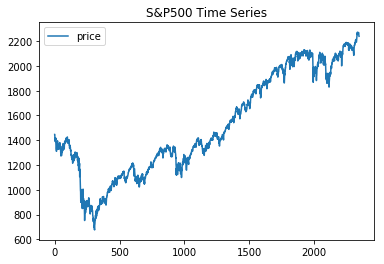

In [3]:
sp_data.plot()
plt.title('S&P500 Time Series')
plt.show()

So, now we have a time series of exchange rate data. Our x-axis doesn't make much sense, though. How could we fix that?

Let's use pandas to create a date based index.

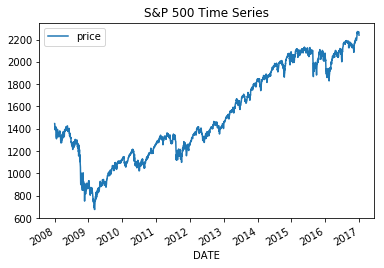

In [4]:
sp_data.index = pd.to_datetime(sp_data.DATE)
sp_data.plot()
plt.title('S&P 500 Time Series')
plt.show()

That's better. Now we have a sense of the amount of time actually covered by our time series. As we discussed previously, however, we need a stationary data set. This looks as though it might have a trend to it, so let's try plotting the difference.

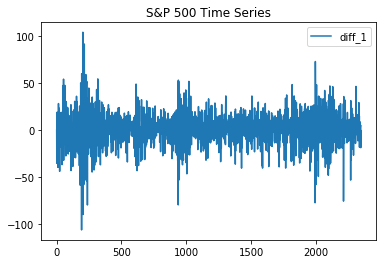

In [4]:
sp_data['diff_1'] = sp_data.price - sp_data.price.shift()
sp_data.plot(y='diff_1')
plt.title('S&P 500 Time Series')
plt.show()

We'll also want to investigate the PACF. Let's look at the PACF for both the initial and differenced time series.

Text(0.5, 1.0, 'S&P PACF')

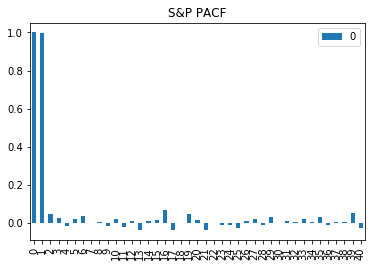

In [5]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(sp_data.price))
x_acf.plot(kind='bar')
plt.title("S&P PACF")

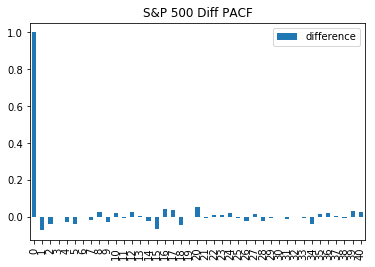

In [6]:
x_acf = pd.DataFrame(pacf(sp_data.diff_1[1:]))
x_acf.plot(kind='bar')
plt.title("S&P 500 Diff PACF")
plt.legend(['difference'])

## Building models.

So our initial time series has 1 strong autocorrelation but the differences seem to show no real autocorrelation. Let's build some ARIMA models to experiment and see how we do!

We're going to build a series of models to evaluate, each with slightly different parameters for the ARIMA. Note that the parameteres are passed in (p, d, q) order, corresponding to the AR, I, and MA portions respectively.

Recall how we interpret those attributes. The AR is the past values, I is the level of differencing, and MA is adjusting to past errors.

In [8]:
from statsmodels.tsa.arima_model import ARIMA

'''
p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, 
    also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.
'''

def build_arima(p,d,q):
    model = ARIMA(sp_data.price, order=(p,d,q))
    model_fit = model.fit()
    print(model_fit.summary())
    print('Residuals Description')
    print(model_fit.resid.describe())
    return (model, model_fit)
    
# with p, q = 0 and d > 0, only model the lagged difference
model, model_fit = build_arima(0,1,0)

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 2266
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9602.159
Method:                           css   S.D. of innovations             16.753
Date:                Thu, 14 Mar 2019   AIC                          19208.317
Time:                        18:31:35   BIC                          19219.769
Sample:                             1   HQIC                         19212.496
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3494      0.352      0.993      0.321      -0.340       1.039
Residuals Description
count    2.266000e+03
mean    -2.257682e-16
std      1.675631e+01
min     -1.069694e+02
25%     -7.314369e+00

In [13]:
'''
    p = 1 and d, q = 0 is just an AR model
'''
build_eval_arima(1,0,0)

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 2267
Model:                     ARMA(1, 0)   Log Likelihood               -9609.725
Method:                       css-mle   S.D. of innovations             16.753
Date:                Thu, 14 Mar 2019   AIC                          19225.449
Time:                        16:28:29   BIC                          19242.628
Sample:                             0   HQIC                         19231.717
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1697.6970    333.118      5.096      0.000    1044.797    2350.597
ar.L1.price     0.9993      0.001   1569.753      0.000       0.998       1.001
                                    Roots       

In [14]:
'''
    p, q = 1 with d = 0 is simply an ARMA model (no differencing)
'''
build_eval_arima(1,0,1)

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                 2267
Model:                     ARMA(1, 1)   Log Likelihood               -9603.247
Method:                       css-mle   S.D. of innovations             16.705
Date:                Thu, 14 Mar 2019   AIC                          19214.494
Time:                        16:29:38   BIC                          19237.398
Sample:                             0   HQIC                         19222.851
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1713.0802    346.564      4.943      0.000    1033.827    2392.334
ar.L1.price     0.9994      0.001   1779.609      0.000       0.998       1.000
ma.L1.price    -0.0787      0.022     -3.614    

In [15]:
'''
    p, d and q = 1 indicate an ARMA model using 1 difference
'''
build_eval_arima(1,1,1)

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 2266
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9592.974
Method:                       css-mle   S.D. of innovations             16.685
Date:                Thu, 14 Mar 2019   AIC                          19193.947
Time:                        16:31:19   BIC                          19216.850
Sample:                             1   HQIC                         19202.304
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3529      0.289      1.222      0.222      -0.213       0.919
ar.L1.D.price     0.5832      0.155      3.765      0.000       0.280       0.887
ma.L1.D.price    -0.6565      0.144     

In [16]:
'''
    * First take the difference (d = 1)
    * Then regress on the previous 5 prices
    * Then compute the error term, using the previous 5 errors
'''
build_eval_arima(5,1,5)

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 2266
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -9588.740
Method:                       css-mle   S.D. of innovations             16.638
Date:                Thu, 14 Mar 2019   AIC                          19201.480
Time:                        16:36:21   BIC                          19270.189
Sample:                             1   HQIC                         19226.549
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3438      0.289      1.188      0.235      -0.224       0.911
ar.L1.D.price    -0.7797      0.162     -4.818      0.000      -1.097      -0.463
ar.L2.D.price    -0.4856      0.221     

Now, we haven't covered all of the output given by statsmodels summary function (if you want to dive deeper, we'd recommend you start diving [here](http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)). What we're most interested in here are the p values of the coefficients, the log likelihood, and the residuals statistics.

Now, the p-values are a way of approximating the likelihood that the coefficient has a significant effect on our outcome, though again it is formally a probability of more extreme results. It allows us to craft the 95% confidence interval for that coefficient. If zero is within that interval, than that coefficient is often considered to be potentially unnecessary.

The log-likelihood is a log of the likelihood that the given model would generate the data we see. The closer to zero, the higher the probablity we are to have predicted our outcome with our given model.

What you can tell from these models, however, is that the outcomes are not great. There is not a huge difference in performance across the models and they all seem generally pretty weak.  

**Go with the (1,1,1) ARIMA model, has the lowest AIC. However, log-likelihood slightly favors the (5,1,5) model over the (1,1,1) model.**  



## Residuals

Now, the last thing we want to introduce here are residuals. Residuals are basically what is left over when we build our model, or the difference between our prediction and the observed quantity. In time series residuals are typically pretty important. You want your residuals to be random and normally distributed. That's the assumption made about errors in linear modeling.

So how can we validate this?

Let's look at our ARIMA(1,1,1) residuals and see.

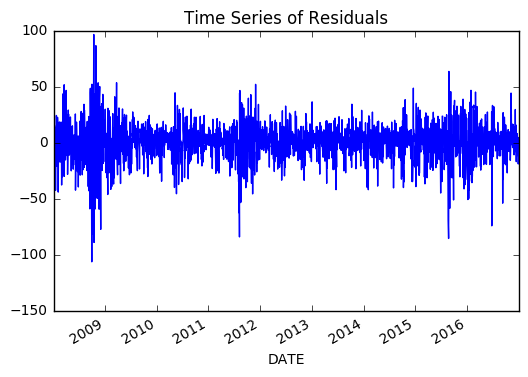

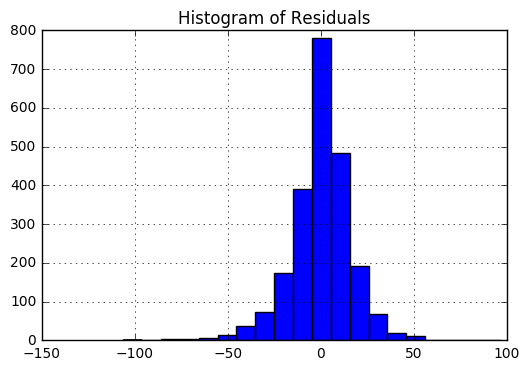

In [21]:
residuals = pd.DataFrame(model_111_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')


When we look at these residuals plots, we can make two reasonable assumptions. Firstly, there isn't a clear trend in the residuals. There are definitely places of higher volatility, and our model could be expanded to include not time series elements that could account for that variation (by that we mean typical regression coefficients as we did in the linear modeling sections before, though this would require a dataset that includes such features). However, there isn't a clear trend to the data indicating an obviously missed seasonality.

Secondly, our residuals seem approximately standard normal. There is a very long tail on the lower end, but that is a very small number of observations that are likely outliers or caused by some external influence.

## Interpretting the ARIMA (1,0,1)

Before we move on to the Challenge for this section, let's return to model interpretation. We've spent this time building models, but we haven't really talked about what our output means. Our ARIMA(1,0,1) is makes a good example for a quick interpretation.

Firstly, the constant is approximately 1700. Then each day is approximately equal to the previous day's value. This is explained through the AR1 coefficient being approximately .9994. The moving average term is approximately .08, meaning that it will move against the previous error by about 8%. These two combine to show a is steadily at the same level as the previous value, but compensating back slightly against any error.

Can you interpret the output of one of the other models? What about ARIMA(1,1,1)? Which do you prefer? Then try some of your own coefficients below.

**Since d = 1 we are now modeling the daily differences in price. Our initial difference is 0.3529, then each day it retains about 60% of this difference with the daily error moving against the previous error by about 65%.**

In [10]:
from sklearn.metrics import mean_squared_error
# Your code here.
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [11]:
# evaluate parameters
p_values = range(0,5)
d_values = [1]
q_values = range(0, 5)
evaluate_models(sp_data.price.values, p_values, d_values, q_values)

ARIMA(0, 1, 0) MSE=281.175
ARIMA(0, 1, 1) MSE=283.866
ARIMA(0, 1, 2) MSE=284.103
ARIMA(0, 1, 3) MSE=284.447
ARIMA(0, 1, 4) MSE=283.967
ARIMA(1, 1, 0) MSE=283.455
ARIMA(1, 1, 1) MSE=283.730
ARIMA(2, 1, 0) MSE=284.198
ARIMA(2, 1, 1) MSE=284.963
ARIMA(3, 1, 0) MSE=284.505
ARIMA(3, 1, 1) MSE=285.396
ARIMA(3, 1, 2) MSE=283.815
ARIMA(4, 1, 0) MSE=284.196
Best ARIMA(0, 1, 0) MSE=281.175


## Comparing Models with AIC

Now we've generated a series of models, which one works best?

Well, one of the easiest ways to compare time series models is with something called _Akaike Information Criteria_, or AIC. AIC is a measure of the degree of information contained in the model, if you recall some of our discussions of information theory in the Decision Tree section.

Now, conveniently `statsmodels` calculates AIC for us (You can look more at that calculation starting [here](https://www.otexts.org/fpp/8/6). We want to minimize the value of the AIC. The model with the lowest AIC is likely the best model to choose. How much better is calculated using the ratios of AIC's.

When comparing to our minimal AIC, other models are compared in the context of information loss. We calculated the probability that another model minimizes information loss. That calculation is:

$$ exp((AIC_{min} - AIC_{x})/2) $$

This gives our probability of having lost less information with the other model.

For our examples, ARIMA(1,1,1) has an AIC of 19193. Our worst model has an AIC of 19225 (It's our ARIMA(1,0,0) or AR(1) model). But how do they compare?

It turns out, when doing the above calculation, we get a probability of 1.125e-7 that we lost less information in our AR(1) model. That is a big difference and suggests that ARIMA(1,1,1) is a much better model.

Compare the other models to ARIMA(1,1,1) below.

In [ ]:
# Use some Python to do the calculations here